**Goals for this Notebook:**

Having conducted an initial analysis, I have gained a comprehensive understanding of the dataset, including valuable insights into the main customer segments and the overall data structure.

In this notebook, I will focus on analyzing the results of our A/B testing. The process is structured as follows:

**Chapter 00: Files preparation**
- Ensure all necessary files are correctly prepared and loaded for the analysis.
  
**Chapter 01: Defining the Metrics Base**
  - Define the criteria for a valid session, which involves setting specific rules to accurately capture user visits to the website.
  - Define the rest of the metrics for the data: steps back, total steps etc.

**Chapter 02: Measuring KPIs and Testing Hypotheses**
  - Measure the Key Performance Indicators (KPIs) to evaluate the performance of the test and control groups.
  - Compare the completion rates of the online process between the test and control groups.
  - Conduct statistical tests to validate the hypotheses and determine the significance of the results.

This structured approach will ensure a thorough and accurate analysis of the A/B test outcomes.

# 00. Files preparation

## Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # used for the legend at step duration
import seaborn as sns
import numpy as np
import datetime
import scipy.stats as st
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
from scipy.stats import norm
import scipy.stats as stats

from functions import cleaning 

from functools import reduce

In [2]:
# Disabling a specific type of warning from Jupyter, that I know if mistaken for something else
pd.options.mode.chained_assignment = None 

## Loading dataset

Datasets provided by Ironhack.

In [3]:
filepath1 = '../Data/df_final_demo.txt' # Client Profiles
filepath2 = '../Data/df_final_web_data_pt_1.txt' # Digital Footprints, part 1
filepath3 = '../Data/df_final_web_data_pt_2.txt' # Digital Footprints, part 2
filepath4 = '../Data/df_final_experiment_clients.txt' # Experiment Roster 

# Loading datasets
df_clients = pd.read_csv(filepath1)
df2 = pd.read_csv(filepath2)
df3 = pd.read_csv(filepath3)
df_roster = pd.read_csv(filepath4)

# Merging part 1 and 2 of Digital Footprints
df_trace = pd.concat([df2, df3], axis=0, ignore_index=True)

## Data cleaning

In [4]:
# Calling the cleaning function I created at the functions.py file
df_clients, df_trace, df_roster, _ = cleaning(df_clients, df_trace, df_roster)

# 01. Defining the Metrics Base

After inspecting the data, I noticed some inconsistencies and possible errors in the **visit_id**. This is important because for the A/B testing analysis, I need to accurately determine how many clients complete the process and compare the two groups (test and control).

Specifically, I observed that for the same client, the visit_id sometimes changed even when there were only a few seconds between steps (likely due to page refreshes). Conversely, the same visit_id sometimes spanned steps that were days apart.

In a real-life scenario, I would consult the IT team to understand the criteria for assigning visit_id and decide whether it can be trusted. Additionally, I would align this with the business goals, considering the user session duration that the business aims to achieve.

**Since this project uses a public dataset, I will define my own rules for what constitutes a valid session.** To do this, I will:
1. **Calculate Time Between Steps:** Calculate the time between successful steps (steps that move forward, not backward).
2. **Identify Outliers:** Use statistical methods to identify outliers in the time between steps.
3. **Prepare the Files:** Add necessary columns and prepare the data to facilitate the definition of valid sessions.
4. **Define Valid Sessions:** Based on the findings, establish rules to define what constitutes a valid session.
5. **Define Session Metrics:** Preparing the data to measure more metrics like steps back, total step count etc.

## Calculate time between moving forward steps

In [5]:
# will use all the data for that (both from test and control group)
# making a copy to not change the original dataframe
df_step_time = df_trace.copy()

# Changing step names, sorting dataframe and resseting index, to help with the analysis below
df_step_time['process_step'] = df_step_time['process_step'].map({'start':1,'step_1':2,'step_2':3,'step_3':4,'confirm':5})
df_step_time.sort_values(by=['visit_id','date_time'], ascending=False, inplace=True)
df_step_time = df_step_time.reset_index(drop=True)

# Adding new columns with previous visit_id, previous process step and previous time, to help with the analysis below
df_step_time['prev_visit_id'] = df_step_time['visit_id'].shift(-1, fill_value=0)
df_step_time['prev_process_step'] = df_step_time['process_step'].shift(-1, fill_value=0)
df_step_time['prev_date_time'] = df_step_time['date_time'].shift(-1, fill_value='1970-01-01 00:00:00')


# Converting to datetime
df_step_time['date_time'] = pd.to_datetime(df_step_time['date_time'],format='%Y-%m-%d %H:%M:%S')
df_step_time['prev_date_time'] = pd.to_datetime(df_step_time['prev_date_time'],format='%Y-%m-%d %H:%M:%S')


# Adding a new layer, to check how the current step and the previous step compare
df_step_time['subtracting_step'] = df_step_time['process_step'] - df_step_time['prev_process_step']

# Adding a new layer, to find the time between successful steps, and filter out the ones with no useful info
df_step_time['subtracting_date_time'] = df_step_time['date_time'] - df_step_time['prev_date_time']


# Filtering the sample, to the interactions that moved one step forward == 1
# and excluding the ones that had substraction with the placeholder date '1970-01-01 00:00:00' < 10000 days
filtered_df_step_time = df_step_time[(df_step_time['subtracting_step'] == 1) & (
    df_step_time['subtracting_date_time'] < '10000 days 00:00:00') & (
    df_step_time['visit_id'] == df_step_time['prev_visit_id'])]

In [6]:
filtered_df_step_time['subtracting_date_time'].describe()

count                       442623
mean     0 days 00:01:00.451167246
std      0 days 00:01:41.177206532
min                0 days 00:00:00
25%                0 days 00:00:12
50%                0 days 00:00:31
75%                0 days 00:01:09
max                0 days 01:00:36
Name: subtracting_date_time, dtype: object

In [7]:
filtered_df_step_time['subtracting_date_time'].quantile(0.95) #  3 minutes at the 95% percentile

Timedelta('0 days 00:03:25')

### Defining outliers with statistical methods

In [8]:
# defining outliers with the IQR method
IQR = filtered_df_step_time['subtracting_date_time'].quantile(0.75) - filtered_df_step_time['subtracting_date_time'].quantile(0.25)
upper_limit_for_outliers = filtered_df_step_time['subtracting_date_time'].quantile(0.75) + IQR
upper_limit_for_outliers

Timedelta('0 days 00:02:06')

In [9]:
# defining outliers with standard deviation method
filtered_df_step_time['subtracting_date_time'].mean() + filtered_df_step_time['subtracting_date_time'].std()*3

Timedelta('0 days 00:06:03.982786842')

By this sample analysis, it appears that the average duration for a step forward in the online interaction is approximately 2 minutes, with the majority of the observations(95% percentile) within a range of around 3,5 minutes. **To identify outliers, I utilized statistical methods, opting for the Standard Deviation method (multpiplied by 3)**, which indicates that **anything exceeding 6 minutes and 4 seconds should be considered an outlier**.  

I will incorporate the identified duration as a threshold to distinguish between sessions in digital footstep analysis. Considering typical intervals between steps of less than the threshold will help determine continuity within sessions versus potential new sessions.

## Data preparation, Splitting dataset for test and control group

In [10]:
# First separating the datasets for the test and control group
df_roster_test = df_roster[df_roster.variation == 'Test']
df_roster_control = df_roster[df_roster.variation == 'Control']

df_test = df_trace[df_trace.client_id.isin(df_roster_test.client_id.unique().tolist())]
df_control = df_trace[df_trace.client_id.isin(df_roster_control.client_id.unique().tolist())]

In [11]:
def df_prep(df):
    ''' Preparing the data for analysis.
    I created the function, cause the same preparation will be done for two datasets (for test and control group).

    Receives dataframe as parameter and returns updated dataframe.'''

    # Rename column for brevity
    df = df.rename(columns={'process_step': 'step'})

    # Replacing the step names with numbers for analysis purposes (will do subtraction later)
    df['step']  = df['step'].map({'start':1,'step_1':2,'step_2':3,'step_3':4,'confirm':5})
    
    # Sorting dataframe
    df.sort_values(by=['client_id','date_time'], ascending=False, inplace=True)

    # Dropping the columns that are not needed
    df.drop(columns=['visitor_id','visit_id'], inplace=True)
   
    # Resetting index
    df = df.reset_index(drop=True)

    
    # New columns for analysis
    # Adding new columns that I will use for comparison: previous  and next client_id
    df['prev_id'] = df['client_id'].shift(-1, fill_value=0)
    df['next_id'] = df['client_id'].shift(1, fill_value=0)

    # Adding new columns that I will use for comparison: previous and next step
    df['prev_step'] = df['step'].shift(-1, fill_value=0)
    df['next_step'] = df['step'].shift(1, fill_value=0)

    # Adding new columns that I will use for comparison: previous datetime, next datetime
    df['prev_time'] = df['date_time'].shift(-1, fill_value='1970-01-01 00:00:00')
    df['prev_time'] = pd.to_datetime(df['prev_time'],format='%Y-%m-%d %H:%M:%S')

    df['next_time'] = df['date_time'].shift(1, fill_value='1970-01-01 00:00:00')
    df['next_time'] = pd.to_datetime(df['next_time'],format='%Y-%m-%d %H:%M:%S')

    # Adding new columns that I will use for comparison: time difference between current and last step
    df['time_diff_prev'] = df['date_time'] - df['prev_time']

    # Adding new columns that I will use for comparison: step duration (difference of following datime with current one)
    df['time_diff_next'] = df['next_time'] - df['date_time']

    # Adding a new layer, to count the steps back, but making sure that I don't compare different clients
    df['subtract_step'] = np.where(df['client_id'] == df['prev_id'],(df['step'] - df['prev_step']),0)

    
    return df

In [12]:
df_test = df_prep(df_test)
df_control = df_prep(df_control)

## Define valid sessions

**Conditions for Defining Valid Sessions:**

The condition outlined below aim to accurately identify the start of a new session within a sequence of actions:
- **current action is 'step' 1**

   **AND**
- **the previous step is more than 6 minutes and 4 seconds ago OR the previous entry is from a different client**



In [13]:
# here I will add to my dataframes for the test and control group a column that will signify a new session
# creating a definition cause I will do the same for both dataframes (control and test)

def new_session(df):
    ''' Function that signifies which point at the digital fottprints are new sessions, based on the conditions:
    - current action is 'step' 1
    AND
    - the previous step is more than 6 min and 4 s ago OR the previous entry is from a different client

    Receives the dataframe as parameter.
    Returns dataframe with an extra column 'new_session' with True or False.'''

    df['new_session'] = False

    # Threshold of 6 min and 4 seconds as calculated above
    threshold = datetime.timedelta(seconds=364)

    # setting the conditions
    conditions = np.array(
    (df['step'] == 1) & 
    ((df['time_diff_prev'] > threshold) |
    (df['client_id'] != df['prev_id']))
    )

    df.loc[conditions, 'new_session'] = True
    
    # Sorting everything to ascending order, to help with following steps
    df.sort_values(by=['client_id','date_time'], ascending=True, inplace=True)

    return df

In [14]:
df_test = new_session(df_test)
df_control = new_session(df_control)

In [15]:
# Numbering seperate sessions
count = 0  # Initialize count outside the function

def session_id(new_session):
    ''' Function to number the seperate sessions'''
    
    global count  # Access the count variable from outside the function
    
    if new_session == True:
        count += 1
        return count       
    else:
        return count


# Calling session_id that is defined in functions.py
df_test['session_id'] = df_test['new_session'].apply(session_id)


# Doing the same for the 'control' dataframe
count = 0  # Resetting count outside the function

df_control['session_id'] = df_control['new_session'].apply(session_id)

## Session metrics

Conditions:

**Valid Session**:
A valid session is characterized by consecutive steps occurring within a duration of no more than 6 minutes and 4 seconds.

**Invalid Session**:
An invalid session is identified when the time interval between consecutive steps exceeds 6 minutes and 4 seconds.

**Successful Session**:
A successful session is a valid session that successfully reaches the 'confirm' stage after traversing all required steps ('start', 'step1', 'step2', 'step3'). In cases of multiple 'confirm' steps, the last one is regarded as the official confirm. Metrics for successful sessions include quantifying the total number of steps taken, the total number of steps taken backward, and calculating the duration from the session start to the final valid confirm step.

**Unsuccessful Session**:
Unsuccessful session is one that fails to reach the 'confirm' stage completely or reaches 'confirm' without passing through the necessary steps. These sessions may be flagged for further investigation to understand the reasons behind the incomplete or irregular user behavior.

In [16]:
# Variable to count steps until 'confirm'
steps_count = 1
# Variable to count how many steps back there were per session
steps_back = 0
# Variable to count how many valid 'confirms' have been per session
confirm_count = 0
# Variable to check if there are more than 1 'confirm' in the same session
confirmed = False
# Variable to check if the session is valid
valid = True
# Variables to see if per session steps 1,2,3 were completed before 'confirm'
check_1 = False
check_2 = False
check_3 = False
# Variable to measure how long a session that reached 'confirm' lasted
session_start = '1970-01-01 00:00:00'


def session_info(df):
    # To access the variable from outside the function
    global steps_count 
    global steps_back
    global confirm_count
    global confirmed
    global valid
    global check_1
    global check_2
    global check_3
    global session_start

    threshold = datetime.timedelta(seconds=364)
    
    if df['new_session'] == True:
        # Resetting the counts for the new sessions
        steps_count = 1
        steps_back = 0
        confirm_count = 0
        confirmed = False
        valid = True
        session_start = df['date_time']
        session_start = pd.to_datetime(session_start,format='%Y-%m-%d %H:%M:%S')
        check_1 = False
        check_2 = False
        checl_3 = False        
        return [confirm_count, steps_count, steps_back, df['time_diff_next'], pd.NaT, 'valid']

    elif df['time_diff_prev'] < datetime.timedelta(seconds=0):
        # this refers to the few cases, that have the same session id, but different client_id, etc
        # and they are in the same session_id because the new session needs 'start' to be defined.
        # if the next client just started from any other valid, it is invalid, but currently it is 
        # noted as the same session as the one above it.
        valid = False
        return [confirm_count, steps_count, steps_back, pd.NaT, pd.NaT, 'invalid']
    
    elif df['time_diff_prev'] < threshold and valid:
        
        if df['step'] in (1,2,3,4):
            if df['step'] == 2:
                check_1 = True
            elif df['step'] == 3:
                check_2 = True
            else:
                check_3 = True
                
            # Counting the steps back
            if df['subtract_step'] < 0:
                steps_back += abs(df['subtract_step'])            
            
            # Counting the total steps
            steps_count += 1

            return [confirm_count, steps_count, steps_back, df['time_diff_next'], pd.NaT, 'valid']
 
        # At the first valid 'confirm' I am returning the total number of steps
        elif df['step'] == 5 and not confirmed and check_1 and check_2 and check_3:
            confirm_count = 1
            confirmed = True
            steps_count += 1
            session_dur = df['date_time'] - session_start
            return [confirm_count, steps_count, steps_back, pd.NaT, session_dur,'valid']
        
        # When more than one 'confirm' happen within the valid timeframe, I need to return the updated info, 
        # and add a step count for the first 'confirm'
        elif df['step'] == 5 and confirmed and check_1 and check_2 and check_3:
            confirm_count += 1
            session_dur = df['date_time'] - session_start
            steps_count += 1
            return [confirm_count, steps_count, steps_back, pd.NaT, session_dur,'valid']
    
        # Checking the case where'confirm' is reached without passing from all the necessary steps
        elif df['step'] == 5 and not confirmed:
            # I am considering it a valid session but not a successful one
            # I will count it as an extra step, but that can be defined better later
            steps_count += 1
            return [confirm_count, steps_count, steps_back, df['time_diff_next'], pd.NaT, 'valid']
    
    elif df['time_diff_prev'] > threshold and valid:
        valid = False
        return [confirm_count, steps_count, steps_back, pd.NaT, pd.NaT, 'invalid']

    else:
        # this is the case where valid is already False
        return [confirm_count, steps_count, steps_back, pd.NaT, pd.NaT, 'invalid']

In [17]:
# Applying the above function
df_test['session_info'] = df_test.apply(session_info, axis=1)
df_control['session_info'] = df_control.apply(session_info, axis=1)


# Dropping columns that will not be needed further, saving it to a new dataframe with results
df_test_rslt = df_test.drop(columns=(['time_diff_next','time_diff_prev','new_session',
                       'prev_id','next_id','prev_step','next_step','prev_time','next_time']))
df_control_rslt = df_control.drop(columns=(['time_diff_next','time_diff_prev','new_session',
                       'prev_id','next_id','prev_step','next_step','prev_time','next_time']))


# Splitting the session info in more columns
df_test_rslt[['confirm_cnt', 'steps_cnt', 'steps_back_cnt', 'step_dur',
              'sess_dur_to_confirm','validity']] = df_test_rslt['session_info'].apply(pd.Series)
df_control_rslt[['confirm_cnt', 'steps_cnt', 'steps_back_cnt', 'step_dur',
              'sess_dur_to_confirm','validity']] = df_control_rslt['session_info'].apply(pd.Series)


# Dropping the session_info column
df_test_rslt = df_test_rslt.drop(columns=('session_info'))
df_control_rslt = df_control_rslt.drop(columns=('session_info'))


# Correcting invalid step_dur, if more than 6min and 2 sec, they are result of subtracting with the next session's time
conditions = (df_test_rslt['step_dur'] > datetime.timedelta(seconds=363)) | (df_test_rslt['step_dur'] < datetime.timedelta(seconds=0))
df_test_rslt.loc[conditions,'step_dur'] = pd.NaT

conditions = (df_control_rslt['step_dur'] > datetime.timedelta(seconds=363)) | (df_control_rslt['step_dur'] < datetime.timedelta(seconds=0))
df_control_rslt.loc[conditions,'step_dur'] = pd.NaT

# Transforming the duration to seconds
df_test_rslt['step_dur'] = df_test_rslt['step_dur'].dt.total_seconds().apply(lambda x: '{:.0f}'.format(x))
df_control_rslt['step_dur'] = df_control_rslt['step_dur'].dt.total_seconds().apply(lambda x: '{:.0f}'.format(x))

In [18]:
df_test_rslt.head()

,client_id,step,date_time,subtract_step,session_id,confirm_cnt,steps_cnt,steps_back_cnt,step_dur,sess_dur_to_confirm,validity
176698,1001101,1,2017-04-05 16:55:20,0,1,0,1,0,13,NaT,valid
176697,1001101,2,2017-04-05 16:55:33,1,1,0,2,0,29,NaT,valid
176696,1001101,3,2017-04-05 16:56:02,1,1,0,3,0,32,NaT,valid
176695,1001101,2,2017-04-05 16:56:34,-1,1,0,4,1,26,NaT,valid
176694,1001101,3,2017-04-05 16:57:00,1,1,0,5,1,20,NaT,valid


In [19]:
df_control_rslt.head()

,client_id,step,date_time,subtract_step,session_id,confirm_cnt,steps_cnt,steps_back_cnt,step_dur,sess_dur_to_confirm,validity
140535,1000062,1,2017-04-06 15:38:49,0,1,0,1,0,182,NaT,valid
140534,1000062,2,2017-04-06 15:41:51,1,1,0,2,0,10,NaT,valid
140533,1000062,3,2017-04-06 15:42:01,1,1,0,3,0,49,NaT,valid
140532,1000062,4,2017-04-06 15:42:50,1,1,0,4,0,nan,NaT,valid
140531,1000062,5,2017-04-06 15:54:49,1,1,0,4,0,nan,NaT,invalid


# 02. Test/ control group: Performance Metrics

## Completion Rate

Setting hypothesis:

- Null Hypothesis (H0): The completion rate of the test group is equal to the completion rate of the control group. Symbolically, p1=p2.
- Alternative Hypothesis (HA): The completion rate of the test group is not equal to the completion rate of the control group, which can be a two-sided alternative (p1!=p2).

To test this I will perform **test of proportions**:

$$ z = \frac{(p_{1} - p_{2})}{\sqrt{p(1-p) \left (\frac{1}{n_{1}} + \frac{1}{n_{2}}\right ) }}$$
$$p_{1} = \frac{x_{1}}{n_{1}}; p_{2} = \frac{x_{2}}{n_{2}}$$
$$p=\frac{(x_{1}+x_{2})}{(n_{1} + n_{2})}$$

In [20]:
# Total number of sessions per group
n1 = df_test_rslt['session_id'].nunique() # 34883 sessions in total
n2 = df_control_rslt['session_id'].nunique() # 32304 sessions in total

# Total number of sessions that reached confirm
x1 = df_test_rslt[df_test_rslt['confirm_cnt'] == 1]['session_id'].nunique() # 16654 confirmed
x2 = df_control_rslt[df_control_rslt['confirm_cnt'] == 1]['session_id'].nunique() # 13534 confirmed

# Completion Rate
p1 = x1 / n1 # 41.90% control group
p2 = x2 / n2 # 47.74% test group

# Combined proportion
p = (x1 + x2) / (n1 + n2)

In [21]:
print(p1,p2)

0.4771847305475091 0.4191001145759143


In [22]:
# Calculation of standard error and z-statistic
standard_error = np.sqrt(p * (1 - p) * (1 / n1 + 1 / n2))
z = (p1 - p2) / standard_error

print(f"Z-value: {z}")

Z-value: 15.119780251648745


In [23]:
# calculating the p-value
p_value = 2 * norm.cdf(min(z, -z)) # this for 2tailed

print(f"The p-value is {p_value:}")

The p-value is 1.1994218562840938e-51


Conclusions:
- **Statistical Significance**: The extremely small p-value strongly suggests rejecting the null hypothesis. This indicates that the difference in completion rates between the test group and the control group is statistically significant.
- **Effect Interpretation**: With a positive z-value of about 15.12, there is very strong evidence that the test group's completion rate is significantly higher than that of the control group. The magnitude of the z-value underscores the robustness of this difference.

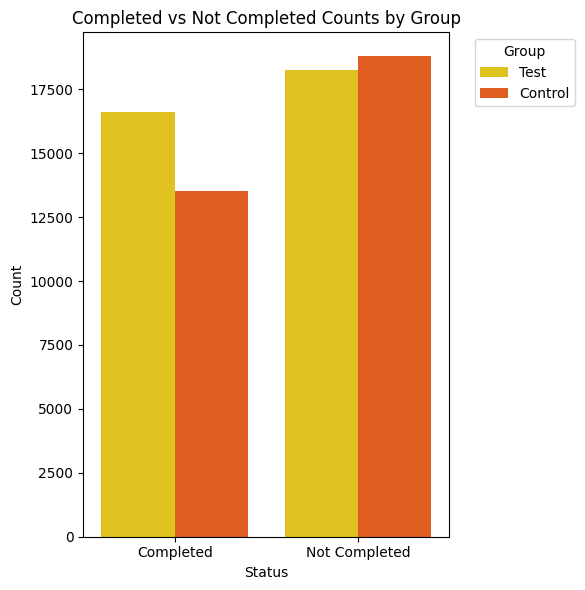

In [24]:
# Plot

# Creating a DataFrame
data = {
    'Group': ['Test', 'Control'],
    'Completed': [16625, 13518],
    'Not Completed': [18258, 18786]
}
df = pd.DataFrame(data)

# Reshaping the DataFrame
df_melted = df.melt(id_vars='Group', var_name='Status', value_name='Count')

# Custom colors for the groups
custom_palette = {'Test': '#FFD700', 'Control': '#FF5200'}

# Plotting
plt.figure(figsize=(6, 6))
sns.barplot(data=df_melted, x='Status', y='Count', hue='Group', palette=custom_palette)
plt.title('Completed vs Not Completed Counts by Group')
plt.xlabel('Status')
plt.ylabel('Count')
plt.legend(title='Group', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
plt.tight_layout() 
#plt.savefig('completed_vs_not_completed_per_group.png')
plt.show()

## Time Spent on Each Step: Detailed Analysis

In [25]:
# this takes into account all the sessions (regardless success/ validity)

# preparing the datasets

# Removing rows with empty values in the 'step_dur' column. In most caseshese empty values occur when it's 
# the last step of the session and there's no next value to compare with
test_step_dur = df_test_rslt[~(df_test_rslt['step_dur'] =='nan')]
control_step_dur = df_control_rslt[~(df_control_rslt['step_dur'] =='nan')]

# Converting step_dur to integers to do numerical operations
test_step_dur['step_dur'] = test_step_dur['step_dur'].astype(int)
control_step_dur['step_dur'] = control_step_dur['step_dur'].astype(int)

# Dropping columns to prepare for the t-test
test_step_dur.drop(columns = ['client_id','date_time','session_id','confirm_cnt',
                              'steps_cnt','steps_back_cnt','sess_dur_to_confirm','validity'], inplace=True)
control_step_dur.drop(columns = ['client_id','date_time','session_id','confirm_cnt',
                                 'steps_cnt','steps_back_cnt','sess_dur_to_confirm','validity'], inplace=True)

# Creating df for each step, for each group, for the t-test
test_step_1_dur = test_step_dur[test_step_dur['step'] == 1]['step_dur'] # 36.9
control_step_1_dur = control_step_dur[control_step_dur['step'] == 1]['step_dur'] # 40.6

test_step_2_dur = test_step_dur[test_step_dur['step'] == 2]['step_dur'] # 45.7
control_step_2_dur = control_step_dur[control_step_dur['step'] == 2]['step_dur'] # 37.1

test_step_3_dur = test_step_dur[test_step_dur['step'] == 3]['step_dur'] # 75.8
control_step_3_dur = control_step_dur[control_step_dur['step'] == 3]['step_dur'] # 79.8

test_step_4_dur = test_step_dur[test_step_dur['step'] == 4]['step_dur'] # 78.6
control_step_4_dur = control_step_dur[control_step_dur['step'] == 4]['step_dur'] # 89.3

Setting hypothesis:

- H0 (Null Hypothesis): The mean time for step 1 in the 'test' group is greater than or equal to the mean time for step 1 in the 'control' group.
- H1 (Alternative Hypothesis): The mean time for step 1 in the 'test' group is less than the mean time for step 1 in the 'control' group.

To test this, I will perform a one-tailed t-test with two samples.

In [26]:
# Conducting the t-test for step 1
t_stat, p_value = stats.ttest_ind(test_step_1_dur, control_step_1_dur, equal_var=False, alternative='less')

print("T-statistic:", t_stat)
print("One-sided P-value (less):", p_value)

T-statistic: -9.138529227101502
One-sided P-value (less): 3.242660843325995e-20


The one-sided t-test results, with a T-statistic of -9.1385 and a p-value of 3.242660843325995e-20, strongly indicate that the test group experiences significantly shorter durations for "step 1" compared to the control group. This finding substantiates the effectiveness of the changes implemented in the test group, suggesting potential benefits for broader adoption.

In [27]:
# Conducting the t-test for step 2
t_stat, p_value = stats.ttest_ind(test_step_2_dur, control_step_2_dur, equal_var=False, alternative='less')

print("T-statistic:", t_stat)
print("One-sided P-value (less):", p_value)

T-statistic: 19.988767218612274
One-sided P-value (less): 1.0


With a p-value of 1.0, we fail to reject the null hypothesis, suggesting that **the mean time for step 2 in the 'test' group is greater than the mean time for step 2 in the 'control' group**.

In [28]:
# Conducting the t-test for step 2 - changing the Alternative Hypothesis
t_stat, p_value = stats.ttest_ind(test_step_2_dur, control_step_2_dur, equal_var=False, alternative='greater')

print("T-statistic:", t_stat)
print("One-sided P-value (less):", p_value)

T-statistic: 19.988767218612274
One-sided P-value (less): 6.906733301530866e-89


The t-test results with the alternative hypothesis as greater indicate a very low p-value (approximately 6.31e-89), suggesting strong evidence against the null hypothesis. This implies that the mean time for step 2 in the 'test' group is significantly greater than the mean time for step 2 in the 'control' group.

In [29]:
# Conducting the t-test for step 3
t_stat, p_value = stats.ttest_ind(test_step_3_dur, control_step_3_dur, equal_var=False, alternative='less')

print("T-statistic:", t_stat)
print("One-sided P-value (less):", p_value)

T-statistic: -7.095943750967559
One-sided P-value (less): 6.512145605275299e-13


The very low p-value suggests strong evidence against the null hypothesis. Therefore, we can conclude that the mean time for step 3 in the 'test' group is significantly lower than the mean time for step 3 in the 'control' group.

In [30]:
# Conducting the t-test for step 4
t_stat, p_value = stats.ttest_ind(test_step_4_dur, control_step_4_dur, equal_var=False, alternative='less')

print("T-statistic:", t_stat)
print("One-sided P-value (less):", p_value)

T-statistic: -14.331960261169387
One-sided P-value (less): 9.193679847468542e-47


The very low p-value suggests strong evidence against the null hypothesis. Therefore, we can conclude that the mean time for step 4 in the 'test' group is significantly lower than the mean time for step 4 in the 'control' group.

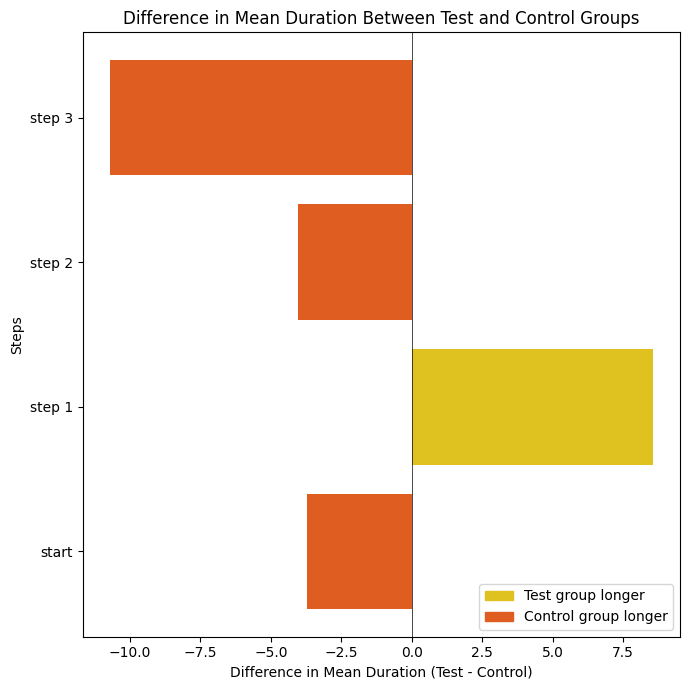

In [31]:
# Plot

# Define the steps
steps = ['start', 'step 1', 'step 2', 'step 3']

# Define the mean durations for each step in the test group
test_means = [test_step_1_dur.mean().round(2), test_step_2_dur.mean().round(2), 
              test_step_3_dur.mean().round(2), test_step_4_dur.mean().round(2)]

# Define the mean durations for each step in the control group
control_means = [control_step_1_dur.mean().round(2), control_step_2_dur.mean().round(2), 
                 control_step_3_dur.mean().round(2), control_step_4_dur.mean().round(2)]


# Calculate the differences between test and control group mean durations
differences = np.array(test_means) - np.array(control_means)

# Set colors for positive and negative differences
colors = ['#DFC120' if diff >= 0 else  '#DF5D20' for diff in differences]

plt.figure(figsize=(7,7))

# Create a diverging bar chart
plt.barh(steps, differences, color=colors)

# Add labels and title
plt.xlabel('Difference in Mean Duration (Test - Control)')
plt.ylabel('Steps')
plt.title('Difference in Mean Duration Between Test and Control Groups')

# Add a vertical line at zero
plt.axvline(x=0, color='black', linewidth=0.5)

# Create legend
blue_patch = mpatches.Patch(color='#DFC120', label='Test group longer')
red_patch = mpatches.Patch(color='#DF5D20', label='Control group longer')
plt.legend(handles=[blue_patch, red_patch], loc='lower right')

# Show plot
plt.tight_layout() 
#plt.savefig('differnce_in_mean_completion_per_group.png')
plt.show()

## Mean Session Duration to Confirmation

In this case:

- **Null Hypothesis (H0):** The mean duration of the test group is greater than or equal to the mean duration of the control group.
- **Alternative Hypothesis (H1):** The mean duration of the test group is less than the mean duration of the control group.
- **Type of Test:** One-sided t-test.

The test is assessing whether there's evidence to suggest that the mean session duration of the 'test' group is significantly less than that of the 'control' group.

In [32]:
# Dropping NaN -> keeping only the rows where sessions reached 'confirm'
df_test_confirm = df_test_rslt.dropna(subset = 'sess_dur_to_confirm')
df_control_confirm = df_control_rslt.dropna(subset = 'sess_dur_to_confirm')

# Select the rows corresponding to the highest 'confirm_cnt' within each group
df_test_confirm_fltrd = df_test_confirm.loc[df_test_confirm.groupby('session_id')['confirm_cnt'].idxmax()]
df_control_confirm_fltrd = df_control_confirm.loc[df_control_confirm.groupby('session_id')['confirm_cnt'].idxmax()]

#df_test_confirm_fltrd['sess_dur_to_confirm'].mean() # 00:04:32.37
#df_control_confirm_fltrd['sess_dur_to_confirm'].mean() # 00:04:41.42

test_confirm_dur = df_test_confirm_fltrd['sess_dur_to_confirm']
control_confirm_dur = df_control_confirm_fltrd['sess_dur_to_confirm']

# transforming the duration to seconds
test_confirm_dur  = test_confirm_dur.dt.total_seconds().apply(lambda x: '{:.0f}'.format(x))
control_confirm_dur  = control_confirm_dur.dt.total_seconds().apply(lambda x: '{:.0f}'.format(x))

test_confirm_dur  = test_confirm_dur [~(test_confirm_dur =='nan')]
control_confirm_dur  = control_confirm_dur [~(control_confirm_dur =='nan')]

# Converting step_dur to integers to do numerical operations
test_confirm_dur = test_confirm_dur.astype(int) # mean: 272.8
control_confirm_dur = control_confirm_dur.astype(int) # mean: 281.9

In [33]:
# Perform the one-sided t-test expecting the mean of the first group to be less than the second
t_stat, p_value = stats.ttest_ind(test_confirm_dur, control_confirm_dur, equal_var=False, alternative='less')

print("T-statistic:", t_stat)
print("One-sided P-value (less):", p_value)

T-statistic: -4.561338698640236
One-sided P-value (less): 2.5515381917959456e-06


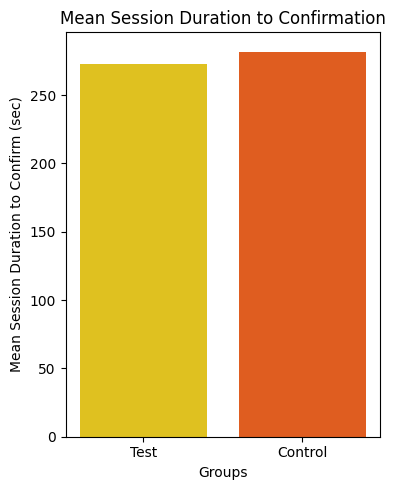

In [34]:
# Plot

# Calculate mean session duration to confirmation for each group
test_mean_dur = test_confirm_dur.mean()
control_mean_dur = control_confirm_dur.mean()

# Data
groups = ['Test', 'Control']
mean_durations = [test_mean_dur, control_mean_dur]

# Plot
plt.figure(figsize=(4, 5))

plt.bar(groups, mean_durations, color=['#DFC120', '#DF5D20'])
plt.xlabel('Groups')
plt.ylabel('Mean Session Duration to Confirm (sec)')
plt.title('Mean Session Duration to Confirmation')
plt.tight_layout() 
#plt.savefig('mean_session_duration_per_group.png')
plt.show()

## Total number of steps

In [35]:
# this takes into account the successful and valid sessions
df_test_confirm_fltrd['steps_cnt'].mean().round(2) # 5.93 
df_control_confirm_fltrd['steps_cnt'].mean().round(2) # 5.78

5.78

In [36]:
st.ttest_ind(df_test_confirm_fltrd['steps_cnt'],df_control_confirm_fltrd['steps_cnt'], equal_var=False, alternative='greater')

TtestResult(statistic=7.393644601181904, pvalue=7.329944738641503e-14, df=29914.34379718722)

The t-test results with the alternative hypothesis set to 'greater' indicate a statistic value of approximately 7.30 and a p-value of approximately 1.52e-13. This suggests that there is strong evidence to reject the null hypothesis in favor of the alternative hypothesis. In other words, **there is a significant difference between the mean number of steps completed in the 'Test' group compared to the 'Control' group, with the 'Test' group having a greater mean number of steps**.

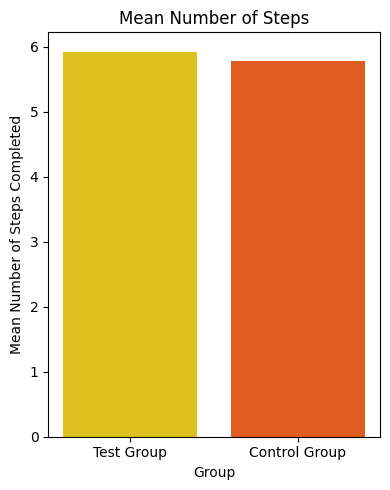

In [37]:
# Plot

# Calculate mean number of steps completed for each group
mean_steps_test = df_test_confirm_fltrd['steps_cnt'].mean()
mean_steps_control = df_control_confirm_fltrd['steps_cnt'].mean()

# Plot
plt.figure(figsize=(4,5))
plt.bar(['Test Group', 'Control Group'], [mean_steps_test, mean_steps_control], color=['#DFC120', '#DF5D20'])
plt.xlabel('Group')
plt.ylabel('Mean Number of Steps Completed')
plt.title('Mean Number of Steps')
plt.tight_layout() 
#plt.savefig('mean_number_steps_per_group.png')
plt.show()

## Error rates

#### Multiple confirms

In [38]:
test_confirm = df_test_rslt[df_test_rslt['confirm_cnt'] == 1]['session_id'].nunique() # 16654 confirmed
control_confirm = df_control_rslt[df_control_rslt['confirm_cnt'] == 1]['session_id'].nunique() # 13534 confirmed

In [39]:
df_test_confirm_fltrd['confirm_cnt'].mean().round(2) # 1.11  <---
df_control_confirm_fltrd['confirm_cnt'].mean().round(2) # 1.05

# because 'confirm_cnt' counts also the first confirm, to find the extra confirm, I need to subtract
test_extra_confirm = df_test_confirm_fltrd['confirm_cnt'].sum() - test_confirm # 1843
control_extra_confirm = df_control_confirm_fltrd['confirm_cnt'].sum() - control_confirm # 695

# Extra confirm rate, percentage to successfull sessions (with 'confirm')
# I choose the successful sessions for this percentage because the steps back are measured from the successfull sessions
test_extra_confirm_rateper_confirm = round(test_extra_confirm *100 / test_confirm,2) # 11.09
control_extra_confirm_rate_per_confirm = round(control_extra_confirm *100 / control_confirm,2) # 5.14

In [40]:
st.ttest_ind(df_test_confirm_fltrd['confirm_cnt'],df_control_confirm_fltrd['confirm_cnt'], equal_var=False, alternative='greater')

TtestResult(statistic=14.125387704080174, pvalue=1.8459794876592185e-45, df=30160.48247031113)

The very small p-value of approximately 2.66e-45 indicates strong evidence against the null hypothesis. Therefore, we reject the null hypothesis and conclude that **the mean confirmed count in the test group is significantly greater than in the control group**.

#### Steps back

In [41]:
# this takes into account the successful and valid sessions
df_test_confirm_fltrd['steps_back_cnt'].mean().round(2) # 0.32  <---
df_control_confirm_fltrd['steps_back_cnt'].mean().round(2) # 0.3

df_test_confirm_fltrd['steps_back_cnt'].sum() # 5318
df_control_confirm_fltrd['steps_back_cnt'].sum() # 3996

3998

In [42]:
st.ttest_ind(df_test_confirm_fltrd['steps_back_cnt'],df_control_confirm_fltrd['steps_back_cnt'], equal_var=False, alternative='greater')

TtestResult(statistic=2.5968163181309234, pvalue=0.004706927674593199, df=29725.855887680318)

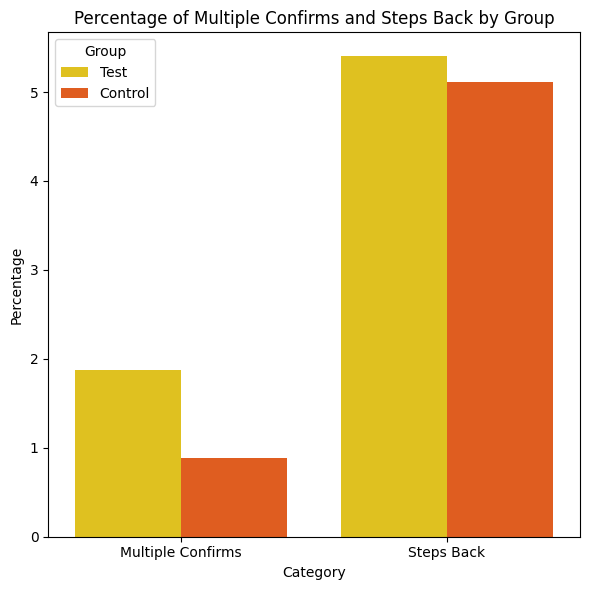

In [43]:
# Plot

test_total_steps = 98532
control_total_steps = 78146
test_extra_confirm = 1843
control_extra_confirm = 695
test_steps_back = df_test_confirm_fltrd['steps_back_cnt'].sum()
control_steps_back = df_control_confirm_fltrd['steps_back_cnt'].sum()

# Calculate percentages
test_confirm_percentage = test_extra_confirm / test_total_steps * 100 # 1.87%
control_confirm_percentage = control_extra_confirm / control_total_steps * 100 # 0.89%
test_steps_back_percentage = test_steps_back / test_total_steps * 100 # 5.40%
control_steps_back_percentage = control_steps_back / control_total_steps * 100 # 5.11%

# Data
data = {
    'Group': ['Test', 'Control'],
    'Multiple Confirms': [test_confirm_percentage, control_confirm_percentage],
    'Steps Back': [test_steps_back_percentage, control_steps_back_percentage]
}
df = pd.DataFrame(data)

# Melt the dataframe
df_melted = pd.melt(df, id_vars='Group', var_name='Category', value_name='Percentage')

custom_palette = {'Test': '#FFD700', 'Control': '#FF5200'}

# Plot
plt.figure(figsize=(6, 6))
sns.barplot(x='Category', y='Percentage', hue='Group', data=df_melted, palette=custom_palette)
plt.title('Percentage of Multiple Confirms and Steps Back by Group')
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.legend(title='Group')
plt.tight_layout() 
#plt.savefig('percentage_confrims_steps_back.png')

plt.show()


In [44]:
# is there any specific step that had more steps back? 

In [45]:
# this takes into account all the sessions (regardless success/ validity)

df_test_step_error = test_step_dur.groupby('step')['subtract_step'].agg(lambda x: (x < 0).count()).reset_index().set_index('step')
df_test_step_error.drop(5, axis=0, inplace=True)
df_control_step_error = control_step_dur.groupby('step')['subtract_step'].agg(lambda x: (x < 0).count()).reset_index().set_index('step')
df_control_step_error.drop(5, axis=0, inplace=True)

table_2 = df_test_step_error.join(df_control_step_error, lsuffix='_test', rsuffix='_control')
table_2

,subtract_step_test,subtract_step_control
step,,
1,44864,34705
2,33897,24916
3,27854,22997
4,21046,17597


In [46]:
# Chi-square test
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(table_2)
chi2_statistic, chi2_p_value

(136.5485353360316, 2.096969777834257e-29)

In [47]:
# Computing the association between variables using the "cramer" method
association(table_2, method="cramer")

0.024479031394353017

That value shows weak association.

## Net Difference in Completion Rates by Age Group: Test - Control

In [48]:
# Adding the age category
bins = [0, 18.0, 25.0, 35.0, 45.0, 55.0, 65.0 , 75.0, 85.0, df_clients['clnt_age'].max()]
labels = ['Under 18 year', '18-24 years', '25-34 years', '35-44 years', '45-54 years', 
          '55-64 years', '65-74 years', '75-84 years', '85 years and older']

df_clients['clnt_age_category'] = pd.cut(df_clients['clnt_age'], bins=bins, labels=labels, include_lowest=True)

# adding the age category column to the result dataframe
df_test_rslt = df_test_rslt.merge(df_clients[['client_id', 'clnt_age_category']], on='client_id', how='left')
df_control_rslt = df_control_rslt.merge(df_clients[['client_id', 'clnt_age_category']], on='client_id', how='left')

In [49]:
completed_test = df_test_rslt[df_test_rslt['confirm_cnt'] == 1].dropna(subset = 'sess_dur_to_confirm')
# getting rid of invalid sessions with the dropna

completed_control = df_control_rslt[df_control_rslt['confirm_cnt'] == 1].dropna(subset = 'sess_dur_to_confirm')

In [50]:
# total test group sessions per age bracket
test_total_age = df_test_rslt.groupby('clnt_age_category', observed=False)['session_id'].nunique().reset_index()

# successful test group sessions per age bracket
test_completed_age = completed_test.groupby('clnt_age_category', observed=False)['session_id'].nunique().reset_index()

# total control group sessions per age bracket
control_total_age = df_control_rslt.groupby('clnt_age_category', observed=False)['session_id'].nunique().reset_index()

# sucessful control group sessions per age bracket
control_completed_age = completed_control.groupby('clnt_age_category', observed=False)['session_id'].nunique().reset_index()

In [51]:
data_frames = [test_total_age, test_completed_age, control_total_age, control_completed_age]
labels = ['test_total', 'test_completed', 'control_total', 'control_completed']


# Rename 'session_id' in each DataFrame uniquely using enumerate for automatic indexing
for index, df in enumerate(data_frames):
    df.rename(columns={'session_id': labels[index]}, inplace=True)

In [52]:
df_merged = reduce(lambda left,right: pd.merge(left,right,on='clnt_age_category',
                                            how='outer'), data_frames)
df_merged.set_index('clnt_age_category', inplace=True)

In [53]:
df_merged['test_percentage_completed'] = round(df_merged['test_completed'] * 100/ df_merged['test_total'],2)
df_merged['control_percentage_completed'] = round(df_merged['control_completed'] * 100/ df_merged['control_total'],2)

df_merged['percentage_diff'] = df_merged['test_percentage_completed'] - df_merged['control_percentage_completed']

In [54]:
df_merged

,test_total,test_completed,control_total,control_completed,test_percentage_completed,control_percentage_completed,percentage_diff
clnt_age_category,,,,,,,
Under 18 year,77,39,91,45,50.65,49.45,1.20
18-24 years,2376,1305,2145,1010,54.92,47.09,7.83
25-34 years,6779,3844,6053,2955,56.70,48.82,7.88
35-44 years,5536,2977,5131,2434,53.78,47.44,6.34
45-54 years,7011,3284,6270,2735,46.84,43.62,3.22
55-64 years,7882,3312,7409,2803,42.02,37.83,4.19
65-74 years,4385,1574,4233,1318,35.90,31.14,4.76
75-84 years,977,251,941,200,25.69,21.25,4.44
85 years and older,124,47,151,29,37.90,19.21,18.69


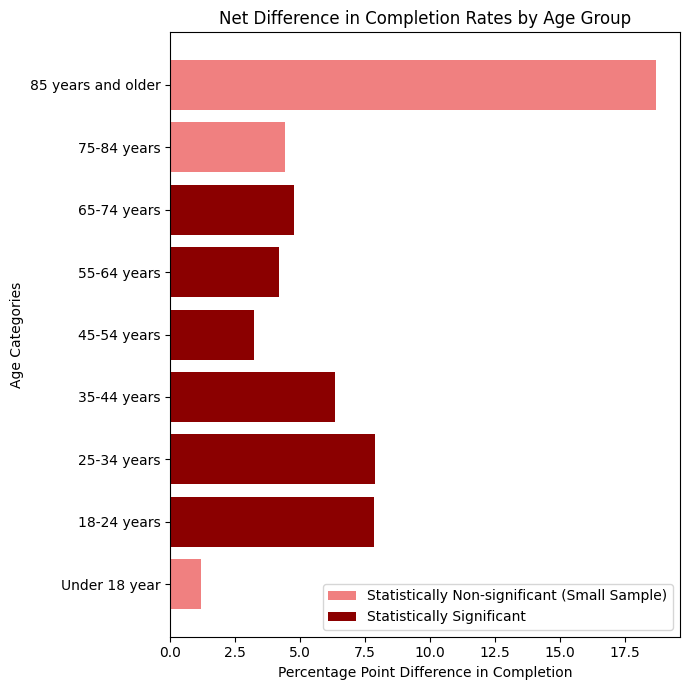

In [55]:
age_categories = df_merged.index
diff = df_merged['percentage_diff']  # This would be your percentage differences data

# Assign colors based on condition (simulated condition here)
colors = ['lightcoral' if age in ['Under 18 year', '75-84 years', '85 years and older'] else 'darkred' for age in age_categories]

plt.figure(figsize=(7, 7))
y_positions = np.arange(len(age_categories))

# Plotting the bars with conditional colors
bars = plt.barh(y_positions, diff, color=colors)

# Creating custom legends
plt.legend([bars[0], bars[1]], ['Statistically Non-significant (Small Sample)', 'Statistically Significant'], loc='best')

# Adding labels and title
plt.xlabel('Percentage Point Difference in Completion')
plt.ylabel('Age Categories')
plt.title('Net Difference in Completion Rates by Age Group')
plt.yticks(y_positions, age_categories)

plt.tight_layout()

#plt.savefig('percentage_difference_test_minus_control.png')

plt.show()

# Making and saving datasets for visualizations

In [56]:
# column for the completion status

In [57]:
completed_condition = (df_test_rslt.confirm_cnt == 1) & (~df_test_rslt.sess_dur_to_confirm.isna())
df_test_rslt.loc[completed_condition, 'completed_status'] = 'completed'

# and now adding to all rows fof the completed sessions the 'completed' status
df_test_rslt['completed_status'] = df_test_rslt['session_id'].map(
    df_test_rslt[df_test_rslt['completed_status'] == 'completed']['session_id'].drop_duplicates().to_dict()
)

# Optionally, fill other rows with 'not completed' if needed
df_test_rslt['completed_status'] = df_test_rslt['completed_status'].fillna('not completed')

In [58]:
# same for control
completed_condition = (df_control_rslt.confirm_cnt == 1) & (~df_control_rslt.sess_dur_to_confirm.isna())
df_control_rslt.loc[completed_condition, 'completed_status'] = 'completed'

# and now adding to all rows fof the completed sessions the 'completed' status
df_control_rslt['completed_status'] = df_control_rslt['session_id'].map(
    df_control_rslt[df_control_rslt['completed_status'] == 'completed']['session_id'].drop_duplicates().to_dict()
)

# Optionally, fill other rows with 'not completed' if needed
df_control_rslt['completed_status'] = df_control_rslt['completed_status'].fillna('not completed')

In [59]:
# session mean duration

In [60]:
# Get the row with the maximum 'confirm_cnt' per session where sessions are confirmed
df_test_confirm = df_test_rslt.dropna(subset = 'sess_dur_to_confirm')

max_confirm_test = df_test_confirm.loc[df_test_confirm.groupby('session_id')['confirm_cnt'].idxmax()]

# Create a dictionary mapping from session_id to the maximum duration
duration_mapping = max_confirm_test.set_index('session_id')['sess_dur_to_confirm'].to_dict()


# Map the durations back to the main DataFrame
df_test_rslt['completed_session_duration'] = df_test_rslt['session_id'].map(duration_mapping)

# making it to seconds to be easier for tableau
df_test_rslt['completed_session_duration_seconds'] = df_test_rslt['completed_session_duration'].dt.total_seconds()

# dropping the sess_dur_to_confirm column
df_test_rslt = df_test_rslt.drop(columns='sess_dur_to_confirm')

In [61]:
# same for control

df_control_confirm = df_control_rslt.dropna(subset = 'sess_dur_to_confirm')

max_confirm_control = df_control_confirm.loc[df_control_confirm.groupby('session_id')['confirm_cnt'].idxmax()]

# Create a dictionary mapping from session_id to the maximum duration
duration_mapping = max_confirm_control.set_index('session_id')['sess_dur_to_confirm'].to_dict()


# Map the durations back to the main DataFrame
df_control_rslt['completed_session_duration'] = df_control_rslt['session_id'].map(duration_mapping)

# making it to seconds to be easier for tableau
df_control_rslt['completed_session_duration_seconds'] = df_control_rslt['completed_session_duration'].dt.total_seconds()

# dropping the sess_dur_to_confirm column
df_control_rslt = df_control_rslt.drop(columns='sess_dur_to_confirm')

In [62]:
# dropiing a few more columns that I will not need
df_test_rslt = df_test_rslt.drop(columns=['validity','completed_session_duration'])
df_control_rslt = df_control_rslt.drop(columns=['validity','completed_session_duration'])

In [63]:
# mean step duration

In [64]:
# adding the step name
df_test_rslt['step_name'] = df_test_rslt.step.map({1:'start',
                                                   2:'step 1',
                                                   3:'step 2',
                                                   4:'step 4',
                                                   5:'confirm'
                                                  })

# same for control
df_control_rslt['step_name'] = df_control_rslt.step.map({1:'start',
                                                   2:'step 1',
                                                   3:'step 2',
                                                   4:'step 4',
                                                   5:'confirm'
                                                  })

In [65]:
# mean number of steps

In [66]:
steps_count_mapping = max_confirm_test.set_index('session_id')['steps_cnt'].to_dict()

# Map the total steps count to the main DataFrame using the session ID
df_test_rslt['total_steps_for_session'] = df_test_rslt['session_id'].map(steps_count_mapping)

df_test_rslt = df_test_rslt.drop(columns='steps_cnt')

In [67]:
# same for control
steps_count_mapping = max_confirm_control.set_index('session_id')['steps_cnt'].to_dict()

# Map the total steps count to the main DataFrame using the session ID
df_control_rslt['total_steps_for_session'] = df_control_rslt['session_id'].map(steps_count_mapping)

df_control_rslt = df_control_rslt.drop(columns='steps_cnt')

In [68]:
# multiple confirms

In [69]:
# Calculate extra confirms by subtracting one from each confirm count
max_confirm_test['extra_confirms_for_session'] = max_confirm_test['confirm_cnt'] - 1

# Create a mapping of session_id to extra_confirms
extra_confirms_mapping = max_confirm_test.set_index('session_id')['extra_confirms_for_session'].to_dict()

# Map the extra confirms to the main DataFrame using the session ID
df_test_rslt['extra_confirms_for_session'] = df_test_rslt['session_id'].map(extra_confirms_mapping)

# Optionally set sessions with no extra confirms to zero
df_test_rslt['extra_confirms_for_session'] = df_test_rslt['extra_confirms_for_session'].fillna(0)

df_test_rslt = df_test_rslt.drop(columns='confirm_cnt')

In [70]:
# same for control

# Calculate extra confirms by subtracting one from each confirm count
max_confirm_control['extra_confirms_for_session'] = max_confirm_control['confirm_cnt'] - 1

# Create a mapping of session_id to extra_confirms
extra_confirms_mapping = max_confirm_control.set_index('session_id')['extra_confirms_for_session'].to_dict()

# Map the extra confirms to the main DataFrame using the session ID
df_control_rslt['extra_confirms_for_session'] = df_control_rslt['session_id'].map(extra_confirms_mapping)

# Optionally set sessions with no extra confirms to zero
df_control_rslt['extra_confirms_for_session'] = df_control_rslt['extra_confirms_for_session'].fillna(0)

df_control_rslt = df_control_rslt.drop(columns='confirm_cnt')

In [71]:
# total steps back per session

In [72]:
total_steps_back = max_confirm_test.groupby('session_id')['steps_back_cnt'].max().reset_index()
total_steps_back.rename(columns={'steps_back_cnt': 'total_steps_back_for_session'}, inplace=True)

# Merge the total step-back counts into the main DataFrame
df_test_rslt = df_test_rslt.merge(total_steps_back, on='session_id', how='left')

# Replace NaN values with 0 for sessions that had no step-backs recorded
df_test_rslt['total_steps_back_for_session'] = df_test_rslt['total_steps_back_for_session'].fillna(0)

df_test_rslt = df_test_rslt.drop(columns=['steps_back_cnt','subtract_step'])

In [73]:
# same for control

total_steps_back = max_confirm_control.groupby('session_id')['steps_back_cnt'].max().reset_index()
total_steps_back.rename(columns={'steps_back_cnt': 'total_steps_back_for_session'}, inplace=True)

# Merge the total step-back counts into the main DataFrame
df_control_rslt = df_control_rslt.merge(total_steps_back, on='session_id', how='left')

# Replace NaN values with 0 for sessions that had no step-backs recorded
df_control_rslt['total_steps_back_for_session'] = df_control_rslt['total_steps_back_for_session'].fillna(0)

df_control_rslt = df_control_rslt.drop(columns=['steps_back_cnt','subtract_step'])

In [75]:
'''
# making and exporting a combined dataset for the Tableau visualizations
df_test_rslt['Group'] = 'Test'
df_control_rslt['Group'] = 'Control'

df_combined = pd.concat([df_test_rslt, df_control_rslt], ignore_index=True)
df_combined.to_excel('../Data/combined_dataset.xlsx', index=False)
'''